# **Simple Real Time Hand Detector**

This tutorial aims to show you a simple method to detect a hand in real time without using the approach of Neural Networks. Therefore, no training is required which allows this method to work on devices that do not have as much processing power, such as some single board computers. This is achieved using a combination of template matching and skin detection. Lets first dive into skin detection. 

Skin detection is a technique used to identify skin pixels from a RGB image. These skin pixels are depicted as white pixels in a binarized image. This is performed using two colour space conversions, RGB to HSV, and, RGB to YCRCB. The HSV and YCRCB channels are used as they provide better separation of chromatic information from luminance, making them more robust to variations in lighting and skin tones compared to the raw RGB color space.

Lets take an image, and convert it into the required colour spaces. To do this, we will use the OpenCV library to perform these conversions.

In [ ]:
import cv2 #Import of OpenCV library
import matplotlib.pyplot as plt #Import of Plotting Library
import numpy as np

Image_1 = cv2.imread("Messi_Ronaldo_IMG.jpg") # This line reads the image into a M x N x 3 array where the '3' represents the number of channels. OpenCV reads images in BGR format.

HSV_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2HSV) # Convert to an HSV Image
YCRCB_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2YCR_CB) # Convert to a YCRCB Image

# Plot the images side by side
plt.figure(figsize=(12, 6))

# Original image
original_Image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2RGB) #Image is converted to RGB for plotting purposes.
plt.subplot(1, 3, 1)
plt.imshow(original_Image)
plt.title("Original Image (RGB)")
plt.axis("off")

# HSV image
plt.subplot(1, 3, 2)
plt.imshow(HSV_image)
plt.title("HSV Image")
plt.axis("off")

# YCrCb image
plt.subplot(1, 3, 3)
plt.imshow(YCRCB_image)
plt.title("YCrCb Image")
plt.axis("off")

# Display the plot
plt.tight_layout()
plt.show()


To perform skin detection using these two colour spaces, a mask will be created using specific channels from these colour spaces. The Saturation channel (S), is extracted from the HSV image, and the chroma channels (Cr and Cb) are extracted from the YCrCb image. A mask is created by selecting values that can provide the optimal skin detected result. It is noted that this skin detection technique is heavily dependant on light, and therefore different values have to be used under different lighting conditions. 

In [ ]:
import cv2
def skin_Detected_Image(HSV_image, YCRCB_image, optimal_Values):
    H, S, V = cv2.split(HSV_image)
    Y, Cr, Cb = cv2.split(YCRCB_image)

    # optimal_Values is an array of optimal values for the mask : [Lower Cr, Upper Cr, Lower Cb, Upper Cb, S]
    skin_Pixels_Image = (optimal_Values[0] <= Cr) & (Cr <= optimal_Values[1]) & (optimal_Values[2] <= Cb) & (Cb <= optimal_Values[3]) & (S <= optimal_Values[4])

    skin_Pixels_Image = skin_Pixels_Image.astype(np.uint8) * 255

    return skin_Pixels_Image

optimal_Values = [142, 175, 75, 155, 255]
skin_Image = skin_Detected_Image(HSV_image, YCRCB_image, optimal_Values)
cv2.imwrite("Skin_Detected_Players.jpg", skin_Image)


# Plot the images side by side
plt.figure(figsize=(16, 16))

# Original image
original_Image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2RGB) #Image is converted to RGB for plotting purposes.
plt.subplot(1, 3, 1)
plt.imshow(original_Image)
plt.title("Original Image (RGB)")
plt.axis("off")

# Skin Detected image
plt.subplot(1, 3, 2)
plt.imshow(skin_Image, cmap="gray")
plt.title("Skin Detected Image")
plt.axis("off")
plt.show()

The results shows how effective the technique was in identifying skin pixels using those values. However, it is seen that the letters behind the individuals, and a few segments on a tshirt showed up as skin pixels. This is because the values found in these segments fall within the range of the skin pixels, and colours that are similar to general skin tones, such as orange, red etc. can show up as skin pixels.

Lets now dive into template matching, which is simply a computer vision method that locates specific regions within an image that resemble a given template. Therefore, a template is used, which is compared to an image and the region within the image, that provides the highest match could signify an accurate detection. One approach in template matching, is making use of the Fast Fourier Transfrom (FFT) method to perform cross-correlation between the template and the image. The frequency domain is used as cross-correlation in this domain is simply element-wise multiplication. Therefore, once both the image and the template are presented in the frequency domain, they can simply be multiplied together to find possible match regions. 

As an example, lets use the graphic found on a t-shirt as the template. 

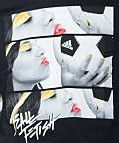

Now lets perform template matching using this template. The template matching function from the OpenCV library will be used, however, this can be implemented from first principles and will be shown as well. 

In [ ]:
Template_image = template = cv2.imread("Tshirt_Template.jpg", 0)

# Convert the main image to grayscale for template matching
gray_main_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2GRAY)

# Perform template matching
result = cv2.matchTemplate(gray_main_image, template, cv2.TM_CCOEFF_NORMED)

# Find the location with the highest match
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Top-left corner of the matched region
top_left = max_loc

# Get the dimensions of the template
template_height, template_width = template.shape

# Bottom-right corner of the matched region
bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

# Draw a rectangle around the detected region
detected_image = Image_1.copy()
cv2.rectangle(detected_image, top_left, bottom_right, (0, 255, 0), 3)

# Convert the image to RGB for displaying with Matplotlib
detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)

# Plot the result
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(result, cmap='gray')
plt.title("Template Matching Result")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(detected_image_rgb)
plt.title("Detected Template Region")
plt.axis("off")

plt.tight_layout()
plt.show()

Now isn't that neat! The template matching result depicts the point with the highest match as seen by the bright white spot in the image. The template matching method was able to identify the location of the template within the image. Lets now implement this from first principles. 

In [ ]:
def normalize(image):
    mean = np.mean(image)
    std = np.std(image)
    if std == 0:  # Avoid division by zero
        return np.zeros_like(image)
    return (image - mean) / (std + 1e-6)

def template_Match_From_Scratch(image, template):
        # Normalize images
    image = normalize(image)
    template = normalize(template)

    # Compute the FFT of the image and padded template

    image_fft = np.fft.fft2(image)
    template_fft = np.fft.fft2(template,s=image.shape)

    # Compute the cross-correlation in the frequency domain
    correlation_fft = image_fft * np.conj(template_fft)

    correlation = np.fft.ifft2(correlation_fft).real

    raw_mean = np.mean(image)
    raw_std = np.std(image)
    template_std = np.std(template)

    correlation = (correlation - raw_mean) / (template.size * raw_std * template_std)

    return correlation

# Perform template matching
result = template_Match_From_Scratch(gray_main_image, template)

# Find the location with the highest match
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Top-left corner of the matched region
top_left = max_loc

# Get the dimensions of the template
template_height, template_width = template.shape

# Bottom-right corner of the matched region
bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

# Draw a rectangle around the detected region
detected_image = Image_1.copy()
cv2.rectangle(detected_image, top_left, bottom_right, (0, 255, 0), 3)

# Convert the image to RGB for displaying with Matplotlib
detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)

# Plot the result
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(result, cmap='gray')
plt.title("Template Matching Result")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(detected_image_rgb)
plt.title("Detected Template Region")
plt.axis("off")

plt.tight_layout()
plt.show()

Now lets move on to the exciting stuff of building a simple real time hand detector! To do this, we will combine the two methods explained above. The template used will be that of a skin detected hand. And the image that will be matched with the template, is an image of a hand that will undergo skin detection. It is noted that the image is resized as the template was created from a resized image, therefore, the image needed to be resized for an accurate detection to be made, otherwise the detected region would be incorrect. 

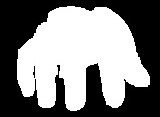

In [ ]:

template = cv2.imread("HAND_TEMPLATE_BLACK.jpg", 0)
template_width = template.shape[1]
template_height = template.shape[0]
Image_1 = cv2.imread("HAND_IMAGE.jpg")
Image_1 = cv2.resize(Image_1, (320,240))


HSV_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2HSV) # Convert to an HSV Image
YCRCB_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2YCR_CB) # Convert to a YCRCB Image


skin_Image = skin_Detected_Image(HSV_image, YCRCB_image, optimal_Values)

# Perform template matching
result = cv2.matchTemplate(skin_Image, template, cv2.TM_CCOEFF_NORMED)

# Find the location with the highest match
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

# Top-left corner of the matched region
top_left = max_loc

# Get the dimensions of the template
template_height, template_width = template.shape

# Bottom-right corner of the matched region
bottom_right = (top_left[0] + template_width, top_left[1] + template_height)

# Draw a rectangle around the detected region
detected_image = Image_1.copy()
cv2.rectangle(detected_image, top_left, bottom_right, (0, 255, 0), 3)

# Convert the image to RGB for displaying with Matplotlib
detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)

# Plot the result
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(result, cmap='gray')
plt.title("Template Matching Result")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(detected_image_rgb)
plt.title("Detected Hand Region")
plt.axis("off")

plt.tight_layout()
plt.show()

From the above result, we can see how using skin detection and template matching, we are able to successfully detect a hand within an image. Now, let us test this technique under a live video feed. In this approach, we will read each frame from the webcam, and perform skin detection. The skin-detected frame will then be matched with the hand template, and the location of the detected hand will be tracked.

In [46]:

cap = cv2.VideoCapture(0) #SELECT ID FOR WEBCAM
while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    frame = cv2.resize(frame, (320,240))
    if not ret:
        break
    
    detected_image = frame.copy()

    HSV_image = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV) # Convert to an HSV Image
    YCRCB_image = cv2.cvtColor(frame, cv2.COLOR_BGR2YCR_CB) # Convert to a YCRCB Image

    skin_Image = skin_Detected_Image(HSV_image, YCRCB_image, optimal_Values)

    result = cv2.matchTemplate(skin_Image, template, cv2.TM_CCOEFF_NORMED)

    match_locations = np.where(result >= 0.45)

    boxes = []
    scores = []

    for (y, x) in zip(*match_locations):
        boxes.append([x, y, template_width, template_height])
        scores.append(result[y, x])

    indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.0, nms_threshold=0.1)
    
    if len(indices) > 0:
        indices = indices.flatten()
        sorted_indices = np.argsort([-scores[i] for i in indices])
        top_indices = sorted_indices[:2] # Show top 2 detections, allowing for up to 2 hands to be detected in an image.

        for ctx, i in enumerate(top_indices):
            idx = indices[i]
            x, y, w, h = map(int,boxes[idx])

            cv2.rectangle(detected_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

    cv2.imshow("Detected Hand", detected_image)

    key = cv2.waitKey(1) & 0xFF    
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Now we have created a simple real time hand detector! This method of combining skin detection and template matching could also be used to detect faces. Let me show you, using a face template and a static image to detect faces. We will use the following template.

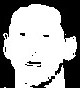

In [ ]:
template = cv2.imread("HEAD_TEMPLATE.jpg", 0)
template_width = template.shape[1]
template_height = template.shape[0]
Image_1 = cv2.imread("Messi_Ronaldo_IMG.jpg")
detected_image = Image_1.copy()

HSV_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2HSV) # Convert to an HSV Image
YCRCB_image = cv2.cvtColor(Image_1, cv2.COLOR_BGR2YCR_CB) # Convert to a YCRCB Image


skin_Image = skin_Detected_Image(HSV_image, YCRCB_image, optimal_Values)

# Perform template matching
result = cv2.matchTemplate(skin_Image, template, cv2.TM_CCOEFF_NORMED)

match_locations = np.where(result >= 0.45)

boxes = []
scores = []

for (y, x) in zip(*match_locations):
    boxes.append([x, y, template_width, template_height])
    scores.append(result[y, x])

indices = cv2.dnn.NMSBoxes(boxes, scores, score_threshold=0.0, nms_threshold=0.1)

if len(indices) > 0:
    indices = indices.flatten()
    sorted_indices = np.argsort([-scores[i] for i in indices])
    top_indices = sorted_indices[:3] # Show top 3 detections, allowing for up to 3 faces to be detected in an image.

    for ctx, i in enumerate(top_indices):
        idx = indices[i]
        x, y, w, h = map(int,boxes[idx])

        cv2.rectangle(detected_image, (x, y), (x + w, y + h), (0, 255, 0), 1)

# Convert the image to RGB for displaying with Matplotlib
detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)

# Plot the result
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(result, cmap='gray')
plt.title("Template Matching Result")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(detected_image_rgb)
plt.title("Detected Hand Region")
plt.axis("off")

plt.tight_layout()
plt.show()
    

Using a single skin-masked template, we could detect all three faces present in this image. The skin-masked template acts as a general template that can be used to detect multiple faces. However, there are limitations to this approach of skin-detection and template matching. Since we are using a skin-masked template, it is possible that if an image contains areas that are highly concentrated in skin pixels, those regions could end up being detected as faces. This is because this model is not trained where we can train it to distinguish between faces and non-faces, instead it is just trying to match a template to an image and areas within the image that match the template will be regarded as probable detections. This method is also not robust to lighting conditions, as optimal skin mask values are different for each lighting condition, however, this can be improved by testing under different lighting conditions and obtaining optimal values for each one. Then using template matching, we can identify which values provide the highest match to the template, and this would be the optimal skin mask values for that specific lighting condition. 

Despite these limitations, this method of combining skin detection and template matching can prove to be quite effective in controlled environments. This could include having to track a hand on a surface to identify where its current location is. This method could also be used in detecting faces in images with a plain background, like those found in identification documents such as passports etc.